# TP: Measuring raw camera calibration accuracy

### Name: **Adib Habbou & Steven Zheng**

The objective of this TP is to perform a simple camera calibration, and measuring its accuracy.

We will go through the following steps:
- Import a raw image containing a ColorChecker chart
- Extract values from color patches in "linear raw RGB" device colorspace
- Find reference color patch values in CIE-XYZ colorspace
- Find a linear 3x3 color calibration matrix
- Perform color rendering and gamma compression
- Assess the quality of the calibration
- Compare the raw image to the JPEG image produced by the same sensor

The purpose of the TP is to introduce the basic concept of calibration to reach the fidelity of color rendering and to assess it using a perceptually uniform color space.

Answer the questions below and then export the notebook with the answers using the menu option File->Download .ipynb. **[Then submit your solution here!](https://docs.google.com/forms/d/e/1FAIpQLSf1RKdUeP3fFogaQ2TqDfSO8fQnxG8dFI-wh7c-ywuLj7BYkA/viewform)**

Install necessary modules:

In [1]:
!pip install colour-science rawpy opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.7 MB/s eta 0:00:00


Import necessary modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import colour
import cv2

In [3]:
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr IspPipeline
    !git clone -b main --single-branch --quiet https://github.com/DXOMARK-OCTO/IspPipeline
    !cp -r IspPipeline/* .

except ImportError:
    # %matplotlib notebook
    pass

%matplotlib inline

import fastisp

# Helper function for displaying images
def imshow(im, **kwargs):
  im = im / im.max()
  plt.figure(figsize=(8, 8))
  plt.imshow(im, **kwargs)
  plt.axis('off')
  plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.2 MB/s eta 0:00:00


# Import a Raw Image

In this section we will import a raw image from a DNG file.
DNG is a universal file format developped by Adobe for raw images.
It contains the raw data from the sensor as well as some metadata useful to transform the raw data to a viewable image.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
filename = "Gretag_6500K_100Lux"
raw = rawpy.imread(rf"./OppoFindX3Pro/ColorChecker/{filename}.dng")

Now let's extract the raw data:

In [6]:
imageB = raw.raw_image[::2, ::2]
imageG2 = raw.raw_image[::2, 1::2]
imageR = raw.raw_image[1::2, 1::2]
imageG1 = raw.raw_image[1::2, ::2]

Let's explore some of the metadata.

In [7]:
bayer_pattern = raw.raw_pattern
print(f"Bayer pattern: {bayer_pattern}")
blc = raw.black_level_per_channel
print(f"Black level: {blc}")
wl  = raw.white_level
print(f"White level: {wl}")

Bayer pattern: [[2 3]
 [1 0]]
Black level: [64, 64, 64, 64]
White level: 1023


Let's display these channels:

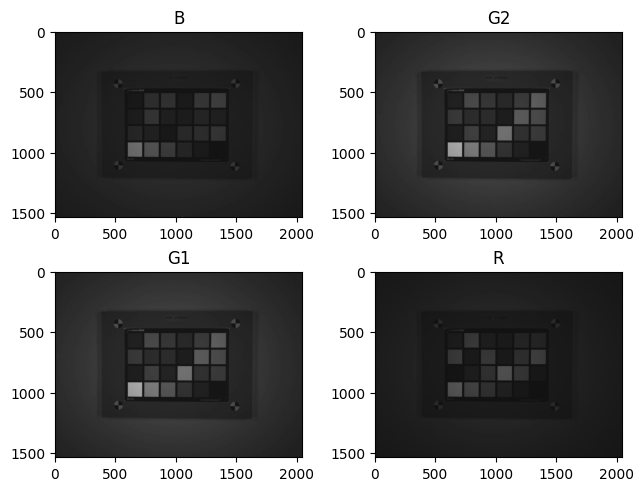

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
axes[0, 0].imshow(imageB, vmin=0, vmax=1024, cmap="gray")
axes[0, 0].set_title("B")
axes[0, 1].imshow(imageG2, vmin=0, vmax=1024, cmap="gray")
axes[0, 1].set_title("G2")
axes[1, 1].imshow(imageR, vmin=0, vmax=1024, cmap="gray")
axes[1, 1].set_title("R")
axes[1, 0].imshow(imageG1, vmin=0, vmax=1024, cmap="gray")
axes[1, 0].set_title("G1")
fig.show()

# Measuring raw sensor RGB response

First, let's find patch ROIs on the ColorChecker:

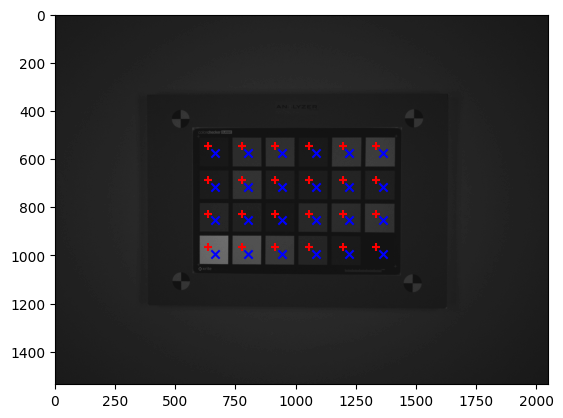

In [9]:
coordinates = ((x0, y0), (x1, y1)) = np.array([
    [580, 490],
    [1420, 1050],
])

rectangles = np.round(np.array([
    [
        [x0 + (0.4+i)/6*(x1-x0), y0 + (0.4+j)/4*(y1-y0)],
        [x0 + (0.6+i)/6*(x1-x0), y0 + (0.6+j)/4*(y1-y0)]
    ] for j in range(4) for i in range(6)
])).astype(int)

plt.imshow(imageB, vmin=0, vmax=1024, cmap="gray")
plt.scatter(*rectangles[:, 0, :].T, marker="+", color="red")
plt.scatter(*rectangles[:, 1, :].T, marker="x", color="blue")
plt.show()

Extract average RGB values from these patches. These RGB values are in an arbitrary "raw RGB" colorspace, which is specific to the camera (sensor and lens included).

In [10]:
patchesR = [np.mean(imageR[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(imageG1[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(imageB[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T

We can show RGB raw values for the gray patches:

In [11]:
patches[18:, :]

array([[ 320.88647959,  638.99362245,  416.77423469],
       [ 251.09311224,  474.27040816,  319.49362245],
       [ 188.38137755,  331.77423469,  230.78316327],
       [ 127.54464286,  200.44770408,  148.99489796],
       [  93.4744898 ,  128.80994898,  104.88265306],
       [  73.93367347,   86.40816327,   78.18494898]])

Note that while this space is called "linear", it is in fact an affine transformation of the amount of light in the scene, since it includes the black level offset from the camera.

We can convert these to "sensor linear RGB" colorspace:

In [12]:
raw_linear_rgb = patches - raw.black_level_per_channel[0]
raw_linear_rgb[18:, :]

array([[ 256.88647959,  574.99362245,  352.77423469],
       [ 187.09311224,  410.27040816,  255.49362245],
       [ 124.38137755,  267.77423469,  166.78316327],
       [  63.54464286,  136.44770408,   84.99489796],
       [  29.4744898 ,   64.80994898,   40.88265306],
       [   9.93367347,   22.40816327,   14.18494898]])

# Measuring the Noise response of the sensor

Let's plot the SNR for one green channel of the gray patches, as a function of the grey level in percentage.

In [13]:
stdR = [np.std(imageR[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
stdG = [np.std(imageG1[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
stdB = [np.std(imageB[py0:py1, px0:px1]) for ((px0, py0), (px1, py1)) in rectangles]
stds = np.vstack((stdR, stdG, stdB)).T

SNR = ( np.array(patchesG[18:]) - blc[0] )/np.array(stdG[18:])
GrayLevels = ( np.array(patchesG[18:]) - blc[0] )/(wl - blc[0])

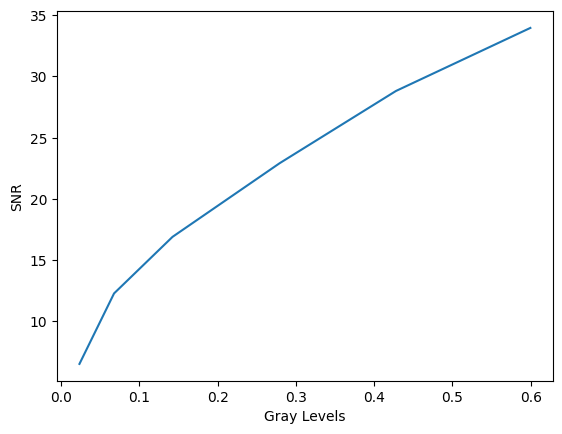

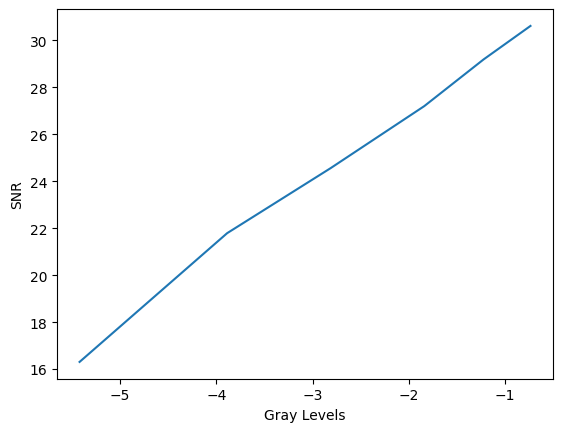

In [14]:
fig = plt.figure()
plt.plot(GrayLevels,SNR)
plt.ylabel('SNR')
plt.xlabel('Gray Levels')
plt.show()

fig = plt.figure()
plt.plot(np.log2(GrayLevels),20*np.log10(SNR))
plt.ylabel('SNR')
plt.xlabel('Gray Levels')
plt.show()

It seems that we have a slope of around 3dB per stop around gray levels of 0.125
Can you estimate the full well capacity in photons with the following hypothesis?

We make the following assumption:
- photon to electron conversion is 100% efficient.
- the sensor is linear
- noise regime is purely photonic at this grey level (RAW data) of 10%

By extending the SNR to the maximum gray level (100%) and squaring the corresponding SNR, we obtain the full well capacity.

$$FWC = (SNR_{max})^2$$

# Find reference patch data

The [Color Checker](https://en.wikipedia.org/wiki/ColorChecker) is a widely used chart in image science. It contains patches of reference color that are well documented.

The [colour-science](https://www.colour-science.org/) library contains reference values in xyY coordinates from various sources, under the D50 illuminant.


In [15]:
colour.CCS_COLOURCHECKERS["BabelColor Average"].data

{'dark skin': array([ 0.4325,  0.3788,  0.1034]),
 'light skin': array([ 0.4191,  0.3748,  0.3525]),
 'blue sky': array([ 0.2761,  0.3004,  0.1847]),
 'foliage': array([ 0.37  ,  0.4501,  0.1335]),
 'blue flower': array([ 0.302 ,  0.2877,  0.2324]),
 'bluish green': array([ 0.2856,  0.391 ,  0.4174]),
 'orange': array([ 0.5291,  0.4075,  0.3117]),
 'purplish blue': array([ 0.2339,  0.2155,  0.114 ]),
 'moderate red': array([ 0.5008,  0.3293,  0.1979]),
 'purple': array([ 0.3326,  0.2556,  0.0644]),
 'yellow green': array([ 0.3989,  0.4998,  0.4435]),
 'orange yellow': array([ 0.4962,  0.4428,  0.4358]),
 'blue': array([ 0.204 ,  0.1696,  0.0579]),
 'green': array([ 0.327 ,  0.5033,  0.2307]),
 'red': array([ 0.5709,  0.3298,  0.1268]),
 'yellow': array([ 0.4694,  0.4732,  0.6081]),
 'magenta': array([ 0.4177,  0.2704,  0.2007]),
 'cyan': array([ 0.2151,  0.3037,  0.1903]),
 'white 9.5 (.05 D)': array([ 0.3488,  0.3628,  0.9129]),
 'neutral 8 (.23 D)': array([ 0.3451,  0.3596,  0.5885])

We actually need the reference values under another illuminant: [D65](https://en.wikipedia.org/wiki/Illuminant_D65) in order to display the resulting image, since the standard sRGB display uses that illuminant.

There are different ways to find an estimate of a XYZ color under an illuminant given the XYZ color coordinates under another illuminant, called "chromatic adaptation" models.

The [Bradford adaptation](http://www.brucelindbloom.com/index.html?Eqn_ChromAdapt.html) is one of the chromatic adaptation models that we propose to use here.

In [16]:
cc_xyY_d50 = np.array([v for v in colour.CCS_COLOURCHECKERS["BabelColor Average"].data.values()])
XYZ_wr_d65 = colour.xy_to_XYZ(colour.CCS_ILLUMINANTS["cie_2_1931"]["D65"])
XYZ_w_d50 = colour.xy_to_XYZ(colour.CCS_ILLUMINANTS["cie_2_1931"]["D50"])
m_d50_to_d65 = colour.adaptation.matrix_chromatic_adaptation_VonKries(XYZ_w_d50, XYZ_wr_d65, "Bradford")
cc_XYZ_d65 = (m_d50_to_d65 @ colour.xyY_to_XYZ(cc_xyY_d50).T).T

print(cc_XYZ_d65)

[[ 0.11367164  0.10216807  0.067859  ]
 [ 0.38073324  0.34891967  0.25549944]
 [ 0.17440606  0.18720906  0.34471351]
 [ 0.1051476   0.13284377  0.0695999 ]
 [ 0.24868724  0.23477596  0.43916727]
 [ 0.30350611  0.42018688  0.45448426]
 [ 0.38256031  0.30435439  0.06310772]
 [ 0.13401642  0.1177579   0.38667971]
 [ 0.28945355  0.19348819  0.13548479]
 [ 0.08514523  0.06484947  0.13774409]
 [ 0.33364715  0.43978245  0.11484894]
 [ 0.46034252  0.42756472  0.07694581]
 [ 0.0787333   0.06100262  0.28416582]
 [ 0.14280639  0.23039038  0.10059871]
 [ 0.20920983  0.12264368  0.05089378]
 [ 0.56697758  0.59861721  0.09308991]
 [ 0.30623523  0.19878174  0.30768514]
 [ 0.14345981  0.19472284  0.39889227]
 [ 0.86341261  0.91239506  0.95751959]
 [ 0.55660076  0.58852863  0.63781236]
 [ 0.34018697  0.3595489   0.39174647]
 [ 0.18060313  0.19124766  0.20904204]
 [ 0.0843512   0.08934444  0.09892032]
 [ 0.03045657  0.03200997  0.03550083]]


# Find the calibration matrix

Thanks to this XYZ D65 references, we will find the best matrix that transform the raw data (proportionnal to luminance in the scene) to XYZ, through least mean square minimization.

In [17]:
# Build a linear system
A = []
b = []
for measured_linear_rgb, reference_xyz in zip(raw_linear_rgb, cc_XYZ_d65):
  A.append(measured_linear_rgb.tolist() + [0, 0, 0, 0, 0, 0])
  A.append([0, 0, 0] + measured_linear_rgb.tolist() + [0, 0, 0])
  A.append([0, 0, 0, 0, 0, 0] + measured_linear_rgb.tolist())
  b.extend(reference_xyz)

A = np.array(A)
b = np.array(b)

# ... and solve it!
x, resid, _, _ = np.linalg.lstsq(A, b, rcond=None)
x = x.reshape((3, 3))

print(f"Residual:{resid}")
print(f"Calibration Matrix:\n{x}")


Residual:[ 0.04548586]
Calibration Matrix:
[[ 0.00160534  0.00047231  0.00028317]
 [ 0.0003649   0.00148986 -0.00030463]
 [-0.00012307 -0.00055902  0.00354769]]


The [colour-science](https://www.colour-science.org/) library provides useful tools to visualize color patches! Let's look at the results.

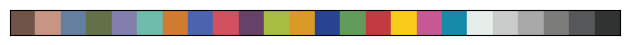

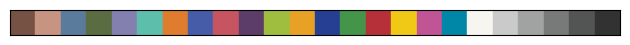

In [18]:
rgb = colour.XYZ_to_sRGB((x @ raw_linear_rgb.T).T)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

rgb = colour.XYZ_to_sRGB(cc_XYZ_d65)
swatches = [colour.plotting.common.ColourSwatch(x) for x in rgb]
colour.plotting.plot_multi_colour_swatches(swatches, coloums=6)
plt.show()

# Applying Calibration

Let's apply the calibration matrix to the image, and observe the results.

(1536, 2048, 3)


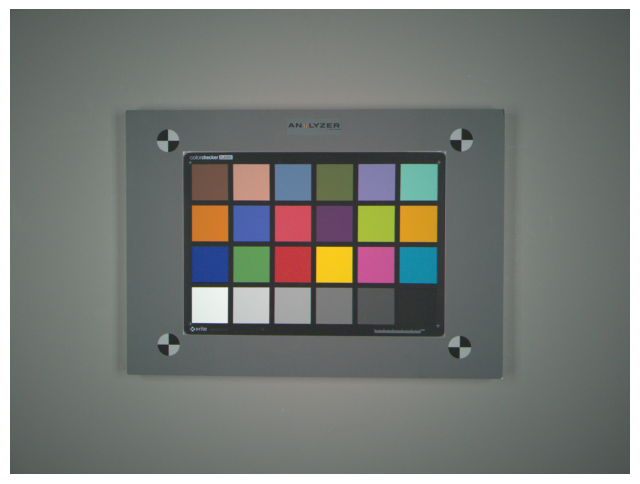

In [48]:
img_raw = np.dstack([imageR, imageG1, imageB]).astype(np.float32) - raw.black_level_per_channel[0]
img_rgb = np.clip(colour.XYZ_to_sRGB((x @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
print(img_rgb.shape)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
cv2.imwrite("img_rgb.jpg",img_bgr)

imshow(img_rgb)
plt.show()

### <font color='blue'>Question:</font>

<ul>

<li><font color='blue'>Can you explain what does the above code?</font></li>

<li><font color='blue'>Can you make the link to the previous processing pipeline that we presented during the last TP?</font></li>

<li><font color='blue'>Where are hidden the demosaicing, white balance, color rendering and gamma steps?</font></li>

</ul>


* This above code processes an image. It first combines separate Red, Green, and Blue color channels into a `3D array`, adjusting for sensor bias. Next, it performs a color space conversion to `sRGB`. The image is then clipped to ensure pixel values are within a valid range. Afterwards, it's converted from `RGB` to `BGR` format. The final image is saved as a `JPEG` file.

* The link with the last TP is that we are applying all the steps of the pipeline (demosaicing, white balance, color rendering and gamma steps) but this time in fewer lines of code.

* The code does not explicitly show the demosaicing, white balance correction, color rendering, and gamma correction steps, but it is assumed that they are encapsulated within the transformation matrix `x` and the `colour.XYZ_to_sRGB` function. Demosaicing might be included in the construction of `img_raw`, white balance correction could be part of `x` or `colour.XYZ_to_sRGB`, color rendering is likely handled by `colour.XYZ_to_sRGB`, and gamma correction is typically included in sRGB color space conversion within the same function. These steps are abstracted, and their specific implementations are not visible in the provided code such as we did in the last TP.

# Comparing to the JPEG generated by the camera

Let's observe the JPEG files provided by the camera.

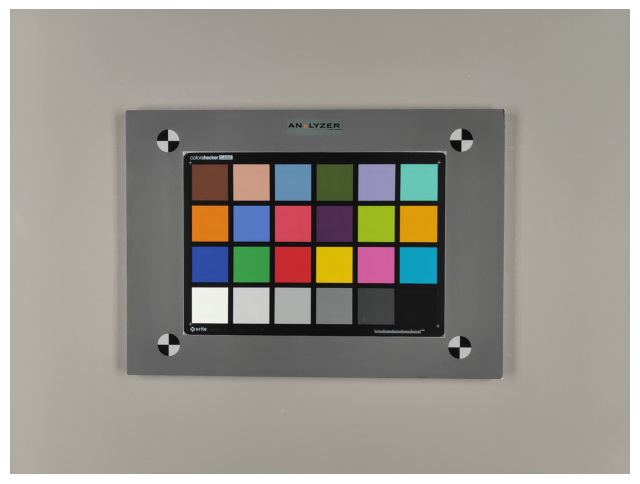

In [20]:
path = r"/content/OppoFindX3Pro/ColorChecker/Gretag_6500K_100lux.jpg"
img_jpg = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)[::2, ::2, :]
imshow(img_jpg)

# Measure the differences between our calibration and the camera JPEG images

We will use the [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) color space to quantify the differences between the images.

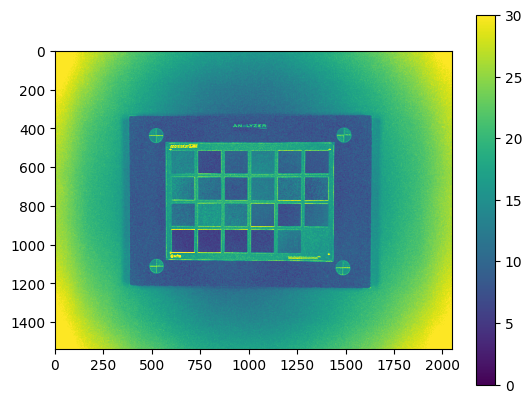

In [21]:
deltalab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_jpg / 255.0)) - colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_rgb))
deltae = np.linalg.norm(deltalab, axis=-1)
plt.imshow(deltae, vmin=0, vmax=30)
plt.colorbar()
plt.show()

In [22]:
patchesR = [np.mean(img_jpg[py0:py1, px0:px1,0]/255) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_jpg[py0:py1, px0:px1,1]/255) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_jpg[py0:py1, px0:px1,2]/255) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T
lab_jpg = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches))

patchesR = [np.mean(img_rgb[py0:py1, px0:px1,0]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(img_rgb[py0:py1, px0:px1,1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(img_rgb[py0:py1, px0:px1,2]) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T
lab_rgb = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches))

deltae_rgb = np.linalg.norm(lab_jpg - lab_rgb, axis=-1)
print(deltae_rgb)

[ 11.53478746   3.20889543   6.67561198  10.56731865   8.15732823
   5.83506993  10.50611566   9.1771648    4.02512592   9.23329067
   8.82152624   5.94590168   6.97358328  15.08116162   9.66906652
   8.38707276   3.74166428   8.47525612   2.53364277   1.55976285
   2.68578261   1.21425904   8.36922133  12.64489251]


# Comparing to our pipeline of TP1



In [23]:
cm = raw.color_matrix[0:3,0:3]
print(f"Color Matrix: {cm}")
wb = np.array(raw.camera_whitebalance)
print(f"White Balance: {wb}")

img_isp = fastisp.isp(raw.raw_image, bayer_pattern, blc[0], 1.8, wb[:3], cm, wl)
ims_isp = img_isp[::2, ::2, :]

patchesR = [np.mean(ims_isp[py0:py1, px0:px1,0]) for ((px0, py0), (px1, py1)) in rectangles]
patchesG = [np.mean(ims_isp[py0:py1, px0:px1,1]) for ((px0, py0), (px1, py1)) in rectangles]
patchesB = [np.mean(ims_isp[py0:py1, px0:px1,2]) for ((px0, py0), (px1, py1)) in rectangles]
patches = np.vstack((patchesR, patchesG, patchesB)).T
lab_isp = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(patches))

Color Matrix: [[ 1.7879809  -0.80493003  0.01694908]
 [-0.1830969   1.2751694  -0.09207252]
 [-0.0547976  -0.6531928   1.7079904 ]]
White Balance: [ 1.98449612  1.          1.59006214  0.        ]


In [24]:
print(patches[21])
print(lab_isp[21])

[ 0.50426805  0.54216305  0.53375786]
[ 56.7473914   -3.95423627  -0.06666053]


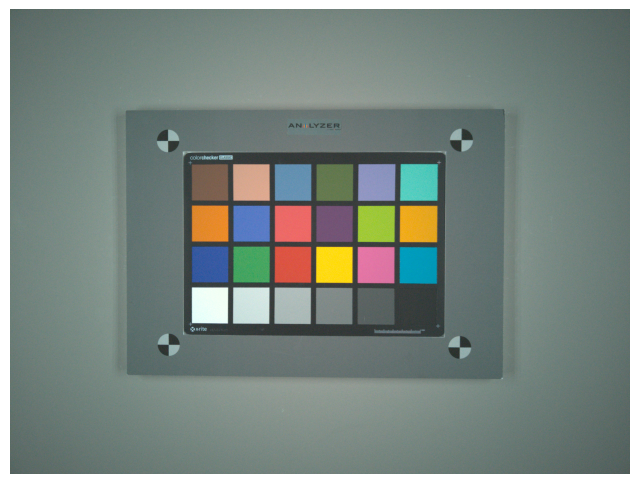

In [25]:
imshow(ims_isp)

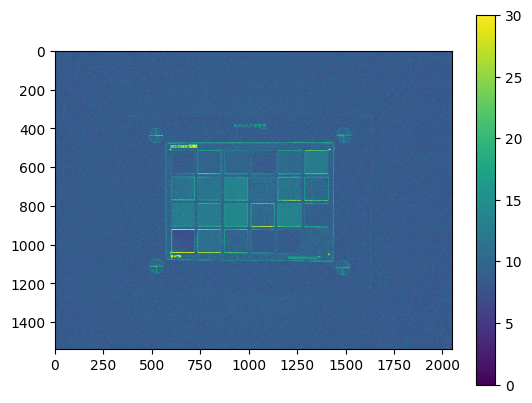

In [26]:
deltalab = colour.XYZ_to_Lab(colour.sRGB_to_XYZ(ims_isp)) - colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_rgb))
deltae = np.linalg.norm(deltalab, axis=-1)
plt.imshow(deltae, vmin=0, vmax=30)
plt.colorbar()
plt.show()

Is the difference between the calibrated image and the isp image perceptually lower than the difference between the calibrated image and the camera image?

In [28]:
deltae_isp = np.linalg.norm(lab_isp - lab_rgb, axis=-1)

print(deltae_isp)
print(deltae_rgb)

[  5.02012032   7.45150167   7.78085074   5.22713812   8.50319904
  11.10917406   9.18631002  10.00753394  12.13893399   8.22676825
  10.13646023   7.95033839  11.34364969  10.94007054  12.70364704
   8.89819432  12.2368078    6.82993001   5.95536704   9.28049566
   7.84456419   6.2419333    5.19915339   4.52376861]
[ 11.53478746   3.20889543   6.67561198  10.56731865   8.15732823
   5.83506993  10.50611566   9.1771648    4.02512592   9.23329067
   8.82152624   5.94590168   6.97358328  15.08116162   9.66906652
   8.38707276   3.74166428   8.47525612   2.53364277   1.55976285
   2.68578261   1.21425904   8.36922133  12.64489251]


In [36]:
print(f"Number of elements where deltae_isp > deltae_rgb: {sum(deltae_isp > deltae_rgb)}")
print(f"Number of elements where deltae_isp < deltae_rgb: {sum(deltae_isp < deltae_rgb)}")

Number of elements where deltae_isp > deltae_rgb: 16
Number of elements where deltae_isp < deltae_rgb: 8


The values in `deltae_isp` are generally higher than those in `deltae_rgb`, which suggests that the calibrated image (`lab_isp`) is closer in color to the camera image (`lab_rgb`) compared to the ISP image. Therefore, the difference between the calibrated image and the ISP image is perceptually lower than the difference between the calibrated image and the camera image.

# Further questions

In this simple example, we took a lot of shortcuts.

* We only ran this example with one illuminant. What happens if you use another illuminant, and why?
* What happens on another device? Will the calibration stay the same? Why, or why not?
* Try to use the calibration on a more realistic image, such as a portrait. What could you improve?
* What color is rendered best, and what color is rendered worst? How could you improve the calibration protocol we used here?
* The camera-generated JPEG can be very different. What additional calibrations do you think they included, and what would their effect be on the color calibration we performed here?

* When using a different illuminant, such as a light source with a different color temperature, the color rendering of the camera will be affected. This is because the spectral composition of the light source changes, leading to variations in how colors are captured and reproduced by the camera's sensor. The calibration process performed above is specific to the illuminant used (D65), and the resulting color calibration matrix is tailored to this particular light source. If a different illuminant is used, the color calibration matrix would need to be re-calculated to account for the new spectral characteristics.

* The calibration will not stay the same on another device. This is because different camera sensors have unique characteristics, such as sensitivities to different wavelengths of light and variations in color response. Additionally, factors like the sensor's noise profile and optical properties can vary between devices. Therefore, a calibration performed on one specific camera will not be directly applicable to another device. Each camera would require its own calibration process to accurately account for its individual characteristics and ensure consistent color rendering.

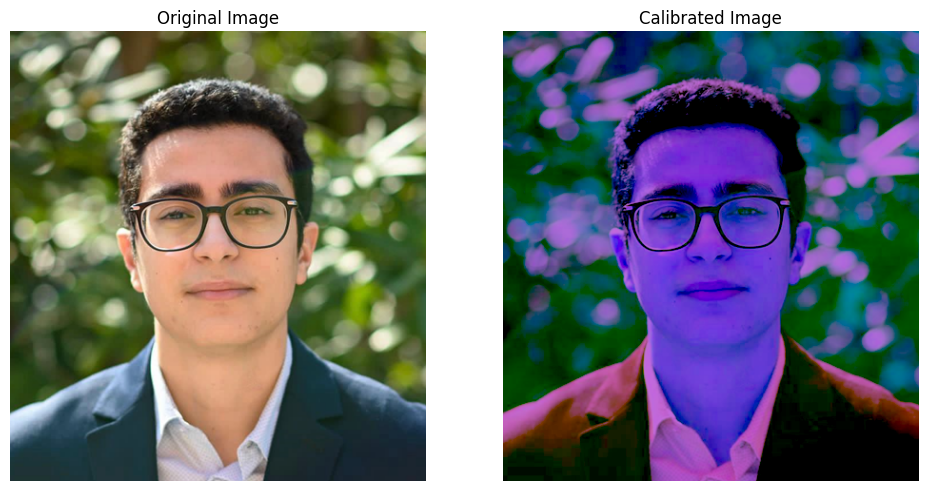

In [66]:
# Load the image
portrait_path = "adib.raw"
portrait = cv2.imread(portrait_path)
portrait = cv2.cvtColor(portrait, cv2.COLOR_BGR2RGB)

# Apply the color calibration
img_raw = portrait.astype(np.float32) - raw.black_level_per_channel[0]
img_rgb = np.clip(colour.XYZ_to_sRGB((x @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
portrait_calibrated = img_bgr

# Display both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(portrait)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Calibrated Image")
plt.imshow(portrait_calibrated)
plt.axis('off')
plt.tight_layout()
plt.show()

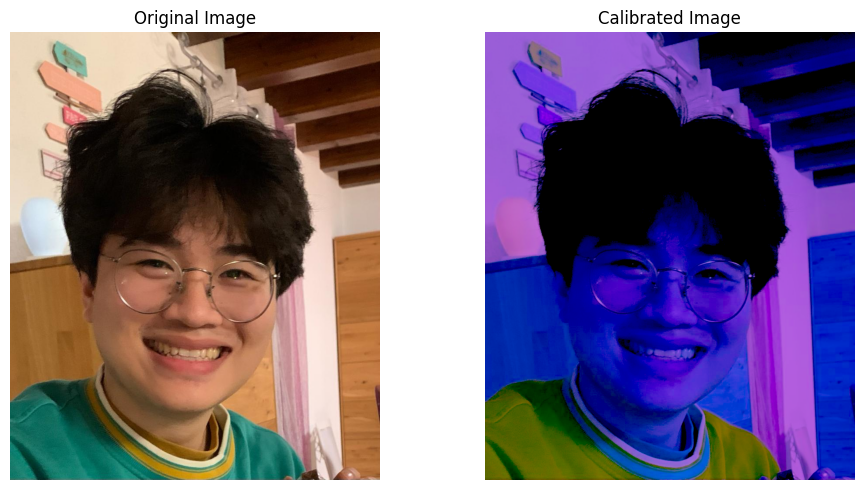

In [67]:
# Load the image
portrait_path = "steven.raw"
portrait = cv2.imread(portrait_path)
portrait = cv2.cvtColor(portrait, cv2.COLOR_BGR2RGB)

# Apply the color calibration
img_raw = portrait.astype(np.float32) - raw.black_level_per_channel[0]
img_rgb = np.clip(colour.XYZ_to_sRGB((x @ img_raw.reshape(-1, 3).T).T.reshape(img_raw.shape)), 0, 1)
img_bgr = cv2.cvtColor(np.array(img_rgb*255,'uint8'), cv2.COLOR_RGB2BGR)
portrait_calibrated = img_bgr

# Display both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(portrait)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Calibrated Image")
plt.imshow(portrait_calibrated)
plt.axis('off')
plt.tight_layout()
plt.show()

* To apply the calibration to a realistic image, such as a portrait, you would need to consider factors like skin tones and various hues that may not be accurately represented using a simple color chart. One improvement could involve fine-tuning the calibration based on the specific color characteristics of human skin. This might involve capturing images with a reference color chart in the same lighting conditions as the portrait and using those values to refine the calibration matrix. Additionally, implementing a more sophisticated color correction algorithm, could further enhance the accuracy of color rendering in complex, real-world scenarios.

* The color that is rendered best would be the one that corresponds to the reference color patch used during calibration. This is because the calibration process is optimized to accurately reproduce this reference color. The color that is rendered worst would be those that deviate significantly from the reference patch in terms of spectral composition. To improve the calibration protocol, one could incorporate a broader range of reference colors, including those that are commonly encountered in real-world scenarios, such as various skin tones. Additionally, using a more sophisticated calibration algorithm that accounts for nonlinear color response and scene-dependent variations could lead to even more accurate and reliable color rendering across a wide range of conditions.

* The camera-generated JPEG likely undergoes additional processing steps beyond the basic color calibration performed here. These steps may include tone mapping, noise reduction, sharpening, and scene-specific optimizations. Tone mapping may affect the contrast and brightness levels, which can influence color perception. Noise reduction and sharpening may also subtly affect color appearance by influencing the clarity and smoothness of edges and textures.These additional calibrations aim to improve the overall visual quality and appeal of the final JPEG image. While the color calibration we performed forms a crucial foundation, these additional adjustments work in conjunction to produce a visually pleasing and accurate representation of the scene.